Reference: https://www.youtube.com/watch?v=57N1g8k2Hwc

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"davek4united988","key":"a67fce7f24b1dfcb48731b9db49d37e4"}'}

In [3]:
!mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
kaggleashwin/population-dataset                                World Population by Countries Dataset (1960-2021)    69KB  2022-08-31 05:30:26           1209         59  1.0              
iamsouravbanerjee/house-rent-prediction-dataset                House Rent Prediction Dataset                        82KB  2022-08-20 13:49:03           9140        245  1.0              
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04           2962        110  1.0              
sveta151/tiktok-popular-songs-2021                             Ti

In [6]:
!kaggle datasets download -d nikitarom/planets-dataset

 99% 1.49G/1.50G [00:35<00:00, 56.4MB/s]
100% 1.50G/1.50G [00:36<00:00, 44.6MB/s]


In [43]:
!unzip /train_v2.csv.zip

Archive:  /train_v2.csv.zip
  inflating: train_v2.csv            
   creating: __MACOSX/
  inflating: __MACOSX/._train_v2.csv  


In [45]:
from google.colab import files
data_to_load = files.upload()

Saving train_v2.csv to train_v2 (1).csv


In [9]:
import sys
import os
import subprocess

from six import string_types

# Make sure you have all of these packages installed, e.g. via pip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy
from skimage import io
from scipy import ndimage
from IPython.display import display

%matplotlib inline

from sklearn.metrics import fbeta_score
import cv2

sns.set(context="notebook", palette="coolwarm", style = 'ticks', font_scale = 1.2, color_codes=True)

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow_addons.metrics import FBetaScore
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools
import shutil
import os
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [13]:
#!pip install tensorflow_addons

In [47]:
labels_df = pd.read_csv('train_v2.csv')
print(labels_df.shape)
labels_df.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [48]:
# Build list with unique labels
label_list = []
labels_count = dict()
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        label_list.append(label)
        if label in labels_count:
            labels_count[label] += 1
        else:
            labels_count[label] = 1
labels_count = dict(sorted(labels_count.items(), key=lambda val: val[1], reverse=True))

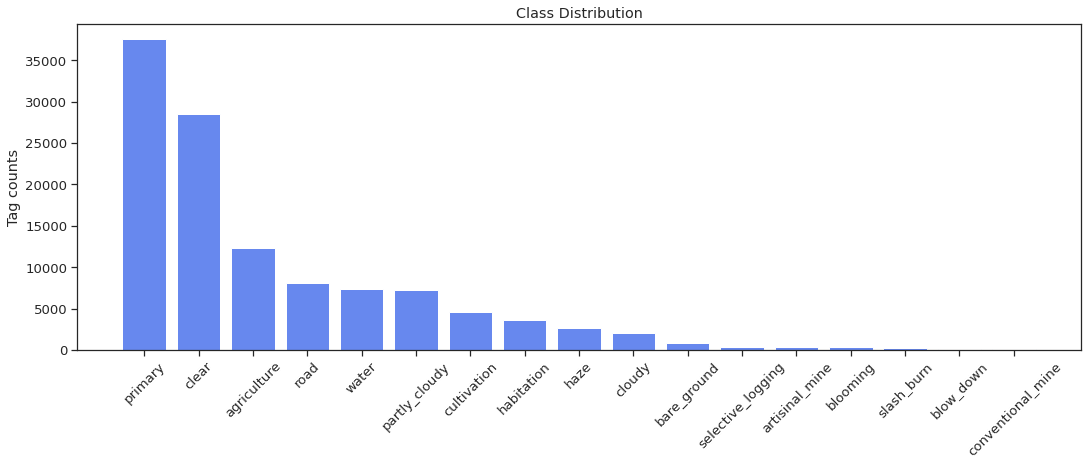

In [86]:
#plot the distribution of the labels
plt.figure(figsize=(18, 6))
plt.title('Class Distribution')
idx = range(len(labels_count.values()))
plt.bar(x=labels_count.keys(), height=labels_count.values())
plt.ylabel('Tag counts')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [49]:
# Add onehot features for every label

for label in list(set(label_list)):
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,conventional_mine,artisinal_mine,primary,cultivation,slash_burn,blooming,road,partly_cloudy,blow_down,habitation,bare_ground,selective_logging,haze,cloudy,water,agriculture,clear
0,train_0,haze primary,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,train_1,agriculture clear primary water,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
2,train_2,clear primary,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,train_3,clear primary,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,train_4,agriculture clear habitation primary road,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if print('Number of GPUs Available', len(physical_devices)):
    tf.config.experimental.set_memory_growth(device=physical_devices[0], enable=True)

In [21]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
directory_path = '/content/planet/planet/train-jpg'
def get_data_iter(data_gen, img_size,label_df, img_list, batch_size, shuffle = True):
    generator = data_gen.flow_from_directory(directory = directory_path,
                                             target_size = img_size,
                                             batch_size = batch_size, class_mode = 'sparse', shuffle = shuffle)
    generator.filenames = img_list
    generator.classes =  label_df.loc[:,label_df.columns !='image_name'].values
    generator.samples = label_df.loc[:,label_df.columns !='image_name'].values.shape[0]
    generator.n = label_df.loc[:,label_df.columns !='image_name'].values.shape[0]
    generator.directory = ''
    generator._set_index_array()
    return generator

In [26]:
directory_path = '../input/planets-dataset/planet/planet/train-jpg'
labels_df['path'] = labels_df.image_name.apply(lambda x: f"{directory_path}/{x}.jpg")

In [54]:
uniq_labels = list(set(label_list))
prepro_fn = tf.keras.applications.vgg19.preprocess_input
train_batches = ImageDataGenerator(preprocessing_function=prepro_fn).flow_from_dataframe(dataframe=labels_df, x_col='image_name',
                                                                                         y_col=uniq_labels,target_size=(224,224),
                                                                                        
                                                                                         class_mode='raw')

Found 0 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 40479 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [51]:
## adding .jpg extension to the column image_name so as to have same name format as the image files
labels_df['image_name'] = labels_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
labels_df.head()

,image_name,tags,conventional_mine,artisinal_mine,primary,cultivation,slash_burn,blooming,road,partly_cloudy,blow_down,habitation,bare_ground,selective_logging,haze,cloudy,water,agriculture,clear
0,train_0.jpg,haze primary,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
2,train_2.jpg,clear primary,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,train_3.jpg,clear primary,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,train_4.jpg,agriculture clear habitation primary road,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,1


In [61]:
#defining our model
def build_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(128, 128, 3)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))

    opt = Adam(lr=1e-4)
    
    # We need binary here, since categorical_crossentropy l1 norms the output before calculating loss.
    model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=[FBetaScore(num_classes=17, beta=2.0)])

    return model

In [52]:
#initializing imagedatagenerator with a validation split of 0.2
train_image_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)
path = '/content/planet/planet/train-jpg'
uniq_labels = list(set(label_list))
#generating train data generator which is 80% of the train dataset
#note that a generator contains both features and target of the data
train_generator = train_image_gen.flow_from_dataframe(dataframe=labels_df,
                                                directory ="/content/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=unique_labels, subset="training", 
                                                batch_size=16,seed=2021, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))

#generating validation data which is expected to be 20% of the train dataset since validation split is 0.2
val_generator = train_image_gen.flow_from_dataframe(dataframe=labels_df,
                                                directory = "/content/planet/planet/train-jpg",  
                                                x_col="image_name", y_col=unique_labels, subset="validation", 
                                                batch_size=16,seed=2021, shuffle=True, 
                                                class_mode="raw", target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [55]:
#setting up step size for training and validation image data
step_train_size = int(np.ceil(train_generator.samples / train_generator.batch_size))
step_val_size = int(np.ceil(val_generator.samples / val_generator.batch_size))

In [62]:
#initialize the model
model1 = build_model()

In [66]:
# Preview the model architecture
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 128, 128, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 63, 63, 64)       

In [68]:
#fitting our model using the parameters already defined 
model1.fit(x = train_generator, 
           steps_per_epoch = step_train_size, 
           validation_data = val_generator, 
           validation_steps = step_val_size,epochs = 25, 
           )

Epoch 1/25
2024/2024 [==============================] - 122s 54ms/step - loss: 0.2085 - fbeta_score: 0.0699 - val_loss: 0.1683 - val_fbeta_score: 0.0758
Epoch 2/25
2024/2024 [==============================] - 108s 53ms/step - loss: 0.1724 - fbeta_score: 0.0929 - val_loss: 0.1540 - val_fbeta_score: 0.0941
Epoch 3/25
2024/2024 [==============================] - 107s 53ms/step - loss: 0.1616 - fbeta_score: 0.0987 - val_loss: 0.1429 - val_fbeta_score: 0.1132
Epoch 4/25
2024/2024 [==============================] - 106s 52ms/step - loss: 0.1527 - fbeta_score: 0.1066 - val_loss: 0.1411 - val_fbeta_score: 0.1008
Epoch 5/25
2024/2024 [==============================] - 106s 52ms/step - loss: 0.1466 - fbeta_score: 0.1086 - val_loss: 0.1344 - val_fbeta_score: 0.1103
Epoch 6/25
2024/2024 [==============================] - 108s 54ms/step - loss: 0.1422 - fbeta_score: 0.1104 - val_loss: 0.1315 - val_fbeta_score: 0.1045
Epoch 7/25
2024/2024 [==============================] - 110s 54ms/step - loss: 0.1

In [70]:
##adding .jpg extension to image name in the sample submission file
sample_submission = pd.read_csv('/content/planet/planet/sample_submission.csv')
sample_submission1 = sample_submission.copy()
sample_submission1['image_name'] = sample_submission1['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission1.head()

,image_name,tags
0,test_0.jpg,primary clear agriculture road water
1,test_1.jpg,primary clear agriculture road water
2,test_2.jpg,primary clear agriculture road water
3,test_3.jpg,primary clear agriculture road water
4,test_4.jpg,primary clear agriculture road water


In [71]:
# Divide the sample submission file into two splits,
# first test1_df which contains the first 40669 images 
test1_df = sample_submission1.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [73]:
#initialize imagedatagenerator for the test images and also rescaling
test_image_gen = ImageDataGenerator(rescale = 1/255)


#creating a generator for the images found in the first test image files
test_generator1 = test_image_gen.flow_from_dataframe(dataframe=test1_df, 
                                                directory="/content/planet/planet/test-jpg", 
                                                x_col="image_name", 
                                                y_col=None, 
                                                batch_size=16, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size1 = int(np.ceil(test_generator1.samples/test_generator1.batch_size))

Found 40669 validated image filenames.


In [74]:
#first, we reset the test generator to avoid shuffling of index as we want it to be orderly
test_generator1.reset()
pred1 = model1.predict(test_generator1, steps = step_test_size1, verbose = 1)

2542/2542 [==============================] - 116s 46ms/step


In [76]:
#getting the filenames in the generator using the attribute .filenames
unique_labels = list(set(label_list))
file_names1 = test_generator1.filenames

 
pred_tags1 = pd.DataFrame(pred1)
pred_tags1 = pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x>0.5]), axis = 1)

#then the result should look like this 
result1 = pd.DataFrame({'image_name': file_names1, 'tags': pred_tags1})
result1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy


In [77]:
#second batch of the test dataset
test2_df = sample_submission1.iloc[40669:]['image_name'].reset_index().drop('index', axis =1)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [79]:
#creating a generator for the second batch of test image files
test_generator2 = test_image_gen.flow_from_dataframe(dataframe=test2_df, 
                                                directory="/content/test-jpg-additional/test-jpg-additional", 
                                                x_col="image_name", 
                                                y_col=None, 
                                                batch_size=16, 
                                                shuffle=False, 
                                                class_mode=None, 
                                                target_size=(128,128))

step_test_size2 = int(np.ceil(test_generator2.samples/test_generator2.batch_size))

Found 20522 validated image filenames.


In [80]:
#we reset the generator to avoid shuffling, then make prediction on the generator
test_generator2.reset()
pred2 = model1.predict(test_generator2, steps = step_test_size2, verbose = 1)

1283/1283 [==============================] - 55s 43ms/step


In [82]:
#this is to get the filenames in the generator using the attribute .filenames
file_names2 = test_generator2.filenames

#convert the predicted values to a dataframe and join two labels together if the probability of occurrance 
#of the label is greater than 0.5
pred_tags2 = pd.DataFrame(pred2)
pred_tags2 = pred_tags2.apply(lambda x: ''.join(np.array(unique_labels)[x>0.5]), axis = 1)

#then the result should look like this
result2 = pd.DataFrame({'image_name': file_names2, 'tags': pred_tags2})
result2.head()

,image_name,tags
0,file_0.jpg,primaryclear
1,file_1.jpg,primaryroadpartly_cloudyagriculture
2,file_10.jpg,primaryroadwater
3,file_100.jpg,primarywaterclear
4,file_1000.jpg,primaryclear


In [84]:

last_result = pd.concat([result1, result2])

last_result = last_result.reset_index().drop('index', axis =1)
last_result['image_name'] = last_result['image_name'].apply(lambda x: x[:-4])
print(last_result.shape)
#print the final result
last_result.head()

(61191, 2)


,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy


In [85]:
# we save the result to a csv file using the .to_csv() 

last_result.to_csv('submission.csv', index = False)

Reference: https://github.com/prof2022/Stage_D_Amozon_Competition/blob/Master/Stage_D_Quiz_Amazon_Competition.ipynb